# A sweep of tone spacing for the AWG calibration

In [1]:
# import the pyMez packages default API
from pyMez import *
# import the Fitting module for Signal Generation and Fitting, note the namespace Code.Analysis.Fitting also works
from pyMez.Code.Analysis.Fitting import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 1.281 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.266 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
The module smithplot was not found,please put it on the python path
It took 2.073 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
It took 0.02 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.32 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.036 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 4.934 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.01 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Nam

## Setup Variables that do not change with tone spacing

In [13]:
# none of these instruments have xml instrument sheets, need to add them
psg_address="GPIB1::19"
vna_address="GPIB1::16"
awg_address="GPIB1::10"
scope_address="GPIB1::7::INSTR"
pm_address="GPIB1::13"
# ----------------------
vna=VNA(vna_address)
scope=HighSpeedOscope(scope_address)
awg=VisaInstrument(awg_address)
# ----------------


# this is local to the computer taking the data, the data should be copied to Q:\public\Aric\AWG_Phase_Calibration_20180927
data_directory=r'C:\Share\AWG_Phase_Calibration_20181001\Predistortion_Zero_Phase'
# Experimental variables

# the psg frequency acts as the master clock
psg_amplitude=12. #psg amplitude in dBm
psg_frequency=10.*10.**9 # 10 GHz
time_step=1./psg_frequency # time step for the awg
fundamental_frequency = 1.*10.**9 # Center of the passband or fundemental frequency in Hz
number_tones = 11 # Number of tones in the modulation bandwidth including the fundamental, should be odd
number_harmonics = 1# Number of harmonics to use. The frequency grid will be n*(f-df), n*f, n*(f+df), etc
# Select the phase for the multisine    
multisine_phase="zero"
#multisine_phase="schroeder"
number_envelopes=1.

# Measurement Phase Reference Setup 
round_multisine_before_writing=True # Rounds the multisine to a desired bitdepth before writing to AWG
bit_depth=8
waveform_name="Calibration_Phase_Reference" # name of the waveform to write to the 
bin_format=True # If the wave is in 16 bit bin format
marker_1=True # If marker one is to be set
marker_1_n_repeats=1 # the rep rate of the marker as a function of number of repeats per time sequence
marker_2=False
marker_2_n_repeats=1

#predistortion 
predistort=True
nominal_scope_amplitude=.005
predistortion_file=r"C:\Share\AWG_Phase_Calibration_20181001\Predistortion_Zero_Phase\C_Awg_Scope.s1p"
predistortion=S1PV1(predistortion_file)
predistortion.change_data_format("MA")
predistortion_amplitudes=predistortion["magS11"]
predistortion_phases=predistortion["argS11"]

# VNA setup 
vna_IFBW=10
comb_frequency = 2.5*10**6
number_phases=10
vna.set_IFBW(vna_IFBW)

The information sheet was not found defaulting to address
The information sheet was not found defaulting to address
The information sheet was not found defaulting to address


In [3]:
pm=NRPPowerMeter(pm_address)

The information sheet was not found defaulting to address


In [4]:
pm.ask("*IDN?")

u'Agilent Technologies,E4417A,SG55376002,A2.05.04\n'

In [5]:
pm.get_reading()

-8.67991025e-07

In [6]:
pm.query("UNIT:POW?")

u'W\n'

In [7]:
pm.write("SENS:FREQ {0}".format(1*10**9))

(22L, <StatusCode.success: 0>)

In [8]:
pm.query("SENS:FREQ?")

u'+1.00000000E+009\n'

In [9]:
# Setup the traces that we might want
# Delete all of the traces that we do not need, in this case I will delete  all of them it leaves one trace
trace_string=vna.query("CALC:PAR:CAT?")
trace_list=trace_string.replace("\n","").split(",")[0::3] #remove endline, split on , and then take every third one
for trace in trace_list:
    vna.write("CALC:PAR:DEL '{0}'".format(trace))
print("Existing traces are {0}".format(vna.query("CALC:PAR:CAT?")))
# set up the traces, we use drive_port=1 sense all of the inputs are turned off, there are combs on port 2, port 3

# first we add a trace for a each reference reciever (R1=a1)
for i in range(4):
    vna.add_trace(trace_name="a{0}".format(i+1),trace_parameter="R{0}".format(i+1),drive_port=1)
# now we add a trace for each b reciever (labelled A,B,C,D)
for i,receiver in enumerate(["A","B","C","D"]):
    vna.add_trace(trace_name="b{0}".format(i+1),trace_parameter="{0}".format(receiver),drive_port=1)
    
# now we want a ratio of R1R4 (a1/a4) <- this is the calibration phase reference / measurement phase reference
vna.add_trace(trace_name="ratio",trace_parameter="R1R4",drive_port="1")
vna.add_trace(trace_name="comb_ratio",trace_parameter="a1b2",drive_port="1")
print("Existing traces are {0}".format(vna.query("CALC:PAR:CAT?")))

Existing traces are "a1,a1,1"

Existing traces are "a1,a1,1,a2,R2,1,a3,R3,1,a4,R4,1,b1,A,1,b2,B,1,b3,C,1,b4,D,1,ratio,R1/R4,1,comb_ratio,a1/b2,1"



In [10]:
tone_spacings=[10*10**6,5*10**6,2.5*10**6,2.5*10**5,2.5*10**4]
tone_spacings=[10*10**6]
comb_spacings=[10*10**6,5*10**6,2.5*10**6]

In [11]:
for tone_spacing in tone_spacings:
    comb_spacing=tone_spacing in comb_spacings
    print(comb_spacing)

True


Calibration Began at 2018-10-19 16:52:40.948000
Sweep 0 
f : 950000000.0
 began at 2018-10-19 16:52:40.948000 
Writing to AWG Began at 2018-10-19 16:52:40.988000 
Measuring on VNA  Began at 2018-10-19 16:52:43.248000 
Measuring on Scope  Began at 2018-10-19 16:52:48.542000 
Writing to AWG Began at 2018-10-19 16:52:51.518000 
Measuring on VNA  Began at 2018-10-19 16:52:53.606000 
Measuring on Scope  Began at 2018-10-19 16:52:58.832000 
Writing to AWG Began at 2018-10-19 16:53:01.816000 
Measuring on VNA  Began at 2018-10-19 16:53:03.853000 
Measuring on Scope  Began at 2018-10-19 16:53:09.106000 
Writing to AWG Began at 2018-10-19 16:53:12.252000 
Measuring on VNA  Began at 2018-10-19 16:53:14.283000 
Measuring on Scope  Began at 2018-10-19 16:53:19.578000 
Writing to AWG Began at 2018-10-19 16:53:22.621000 
Measuring on VNA  Began at 2018-10-19 16:53:24.660000 
Measuring on Scope  Began at 2018-10-19 16:53:30.047000 
Writing to AWG Began at 2018-10-19 16:53:33.077000 
Measuring on VNA 

Writing to AWG Began at 2018-10-19 17:00:38.936000 
Measuring on VNA  Began at 2018-10-19 17:00:41.006000 
Measuring on Scope  Began at 2018-10-19 17:00:46.273000 
Writing to AWG Began at 2018-10-19 17:00:49.250000 
Measuring on VNA  Began at 2018-10-19 17:00:51.290000 
Measuring on Scope  Began at 2018-10-19 17:00:56.609000 
Writing to AWG Began at 2018-10-19 17:00:59.567000 
Measuring on VNA  Began at 2018-10-19 17:01:01.606000 
Measuring on Scope  Began at 2018-10-19 17:01:06.937000 
Writing to AWG Began at 2018-10-19 17:01:09.846000 
Measuring on VNA  Began at 2018-10-19 17:01:11.861000 
Measuring on Scope  Began at 2018-10-19 17:01:17.163000 
Sweep 4 
f : 990000000.0
 ended at 2018-10-19 17:01:20.177000
 taking 103 seonds 
Sweep 5 
f : 1000000000.0
 began at 2018-10-19 17:01:20.177000 
Writing to AWG Began at 2018-10-19 17:01:20.197000 
Measuring on VNA  Began at 2018-10-19 17:01:22.243000 
Measuring on Scope  Began at 2018-10-19 17:01:27.551000 
Writing to AWG Began at 2018-10-19

Measuring on Scope  Began at 2018-10-19 17:08:34.155000 
Writing to AWG Began at 2018-10-19 17:08:37.136000 
Measuring on VNA  Began at 2018-10-19 17:08:39.159000 
Measuring on Scope  Began at 2018-10-19 17:08:44.448000 
Writing to AWG Began at 2018-10-19 17:08:47.416000 
Measuring on VNA  Began at 2018-10-19 17:08:49.473000 
Measuring on Scope  Began at 2018-10-19 17:08:54.760000 
Writing to AWG Began at 2018-10-19 17:08:57.747000 
Measuring on VNA  Began at 2018-10-19 17:08:59.781000 
Measuring on Scope  Began at 2018-10-19 17:09:05.076000 
Writing to AWG Began at 2018-10-19 17:09:08.762000 
Measuring on VNA  Began at 2018-10-19 17:09:10.814000 
Measuring on Scope  Began at 2018-10-19 17:09:16.091000 
Writing to AWG Began at 2018-10-19 17:09:19.268000 
Measuring on VNA  Began at 2018-10-19 17:09:21.325000 
Measuring on Scope  Began at 2018-10-19 17:09:26.653000 
Writing to AWG Began at 2018-10-19 17:09:29.685000 
Measuring on VNA  Began at 2018-10-19 17:09:31.722000 
Measuring on Sco

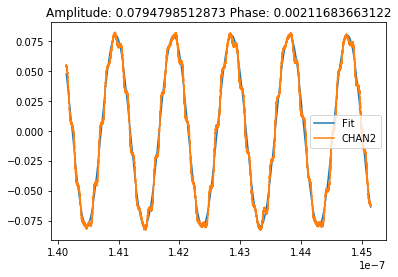

In [16]:
for tone_spacing in tone_spacings:
    comb_spacing = tone_spacing in comb_spacings
    summary_data=[]
    # now calculate the frequency_list
    frequency_list=[]
    for harmonic in range(number_harmonics):
        frequency_array=np.linspace((harmonic+1)*(fundamental_frequency-tone_spacing*(number_tones-1)/2),
                                    (harmonic+1)*(fundamental_frequency+tone_spacing*(number_tones-1)/2),number_tones)
        frequency_list=frequency_list+frequency_array.tolist()
    time_max=number_envelopes/tone_spacing
    number_time_points=int(round(time_max/time_step))
    time_shift=0.*time_step
    sweep_wait_time=2.5*float(len(frequency_list))/float(vna_IFBW)
    sweep_directory=os.path.join(data_directory,"{0}_Tones_{1:.0f}KHz_Spacing".format(number_tones,10**-3*tone_spacing))
    os.mkdir(sweep_directory)
    # first create the multisine
    sine_function=FunctionalModel(parameters=["f","phi"],variables=["t"],equation="cos(2*pi*f*t+phi)")
    time_list=np.linspace(0.+time_shift,time_max+time_shift-time_step,number_time_points)

    # calculate the phases 
    phase_list = [0. for i in range(len(frequency_list))]
    if re.search("sch",multisine_phase,re.IGNORECASE):
        phase_list=[]
        for frequency_index,frequency in enumerate(frequency_list):
            k=(frequency_index+1)%number_tones
            schroeder_phase=-k*(k-1)*np.pi/number_tones
            phase_list.append(schroeder_phase)
    # initialize multisine to a set of zeros
    multisine=np.array([0 for i in range(number_time_points)])
    # add each component
    for frequency_index,frequency in enumerate(frequency_list):
        sine_function.set_parameters({"f":frequency,"phi":phase_list[frequency_index]})
        multisine_component=sine_function(time_list)
        multisine=multisine+multisine_component

    # substract the mean
    # multisine=multisine-np.mean(multisine)
    # normalize the multisine
    # multisine=1/max(multisine)*multisine

    # round the multisine to the nearest bitdepth before writing
    if round_multisine_before_writing:
        discrete_steps=np.linspace(min(multisine),max(multisine),2**bit_depth)
        rounded_multisine=[]
        int_multisine=[]
        for value in multisine:
            difference_array=abs(discrete_steps-value)
            minimum_location=np.argmin(difference_array)
            rounded_multisine.append(discrete_steps[minimum_location])
            int_multisine.append(minimum_location)
        if bin_format:
            multisine=np.array(int_multisine,dtype=np.uint16)
            # Shift, now to add the marker add + 2**14 or +2**15 at the desired location
            multisine=multisine*2**6
        else:
            multisine=rounded_multisine

    # now we add the marker. 
    if marker_1:

        distance=int(np.floor(float(len(multisine))/float(marker_1_n_repeats)))
        for i in range(marker_1_n_repeats):
            try:
                multisine[i*distance]=multisine[i*distance]+2**14
            except:
                pass
    # I am guessing that this has the possibility of kiling the oscope trigger
    if bin_format:
        # turn AWG's output 1 & 2 OFF
        awg.write(':OUTPUT1:STATE OFF')
        awg.write(':OUTPUT2:STATE OFF')
        # wait...
        time.sleep(0.1)
        # UNRUN state
        awg.write('AWGCONTROL:STOP')
        # wait...
        time.sleep(0.5)

        # delete any older waveform with the same name
        awg.write('WLISt:WAVeform:DELete "{0}"'.format(waveform_name))
        time.sleep(0.05)

        # create new waveform
        awg.write('WLISt:WAVeform:NEW "{0}", {1}, INT'.format(waveform_name,len(multisine)))
        # download data
        awg.resource.write_binary_values('WLISt:WAVeform:DATA "{0}",'.format(waveform_name), multisine, datatype='H', is_big_endian=False)
        time.sleep(.1)
        # assign new waveform to channel 1 & 2
        awg.write('SOURce1:WAVeform "{0}"'.format(waveform_name))
        awg.write('SOURce2:WAVeform "{0}"'.format(waveform_name))

        # check for errors
        error_str = awg.query('SYSTEM:ERROR:NEXT?')
        # wait...
        time.sleep(.1)
        # AWG on RUN state
        awg.write('AWGCONTROL:RUN')
        # wait...
        time.sleep(0.5)
        # check if there is any errors on AWG's buffer
        error_str = awg.query('SYSTEM:ERROR:NEXT?')
        if error_str == '0,"No error"\n':
            # turn AWG's output 1 OFF
            awg.write(':OUTPUT1:STATE ON')
            awg.write(':OUTPUT2:STATE ON')

    if number_harmonics is 1:    
        vna.set_frequency((fundamental_frequency-tone_spacing*(number_tones-1)/2),
                                        (fundamental_frequency+tone_spacing*(number_tones-1)/2),number_tones)  
    else:
        for harmonic in range(number_harmonics):
            vna.add_segment((harmonic+1)*(fundamental_frequency-tone_spacing*(number_tones-1)/2),
                                        (harmonic+1)*(fundamental_frequency+tone_spacing*(number_tones-1)/2),number_tones)

    single_cosine=FunctionalModel(variables=["t"],parameters=["f","phi"],equation=".5*cos(2*pi*f*t+phi)")

    phase_sweep_list=[2*np.pi*i/number_phases for i in range(number_phases)]
    # Loop to measure the phase
    start_timer=datetime.datetime.now()
    print("Calibration Began at {0}".format(start_timer))
    for frequency_index,frequency in enumerate(frequency_list[:]):
        begin_sweep_timer=datetime.datetime.now()
        print("Sweep {0} \nf : {1}\n began at {2} ".format(frequency_index,frequency,begin_sweep_timer))
        for phase_index,phase in enumerate(phase_sweep_list):

             #create the sine to write
            # ----------------------------------------------------------------------------------------------------------
            if predistort:
                single_cosine.set_parameters({"f":frequency,"phi":phase-predistortion_phases[frequency_index]})
            else:
                single_cosine.set_parameters({"f":frequency,"phi":phase})
            tone_data=single_cosine(time_list)
            if predistort:
                tone_data=predistortion_amplitudes[frequency_index]*nominal_scope_amplitude*tone_data
            # round the multisine to the nearest bitdepth before writing
            if round_multisine_before_writing:
                discrete_steps=np.linspace(-.5,.5,2**bit_depth)
                rounded_tone_data=[]
                int_tone_data=[]
                for value in tone_data:
                    difference_array=abs(discrete_steps-value)
                    minimum_location=np.argmin(difference_array)
                    rounded_tone_data.append(discrete_steps[minimum_location])
                    int_tone_data.append(minimum_location)
                if bin_format:
                    tone_data=np.array(int_tone_data,dtype=np.uint16)
                    # Shift, now to add the marker add + 2**14 or +2**15 at the desired location
                    tone_data=tone_data*2**6
                else:
                    tone_data=rounded_tone_data

            timer=datetime.datetime.now()
            print("Writing to AWG Began at {0} ".format(timer))
            # write tone to AWG
            # --------------------------------------------------------
            tone_waveform_name="Tone_{0}_Phase_{1:.0f}_Calibration".format(frequency_index,phase*180/np.pi)
            # save the wave for good measure
            out_file=open(os.path.join(sweep_directory,"{0}.bin".format(tone_waveform_name)),"wb")
            out_file.write(tone_data)
            out_file.close()
            # plot 
            plt.close()
            plt.plot(time_list,tone_data)
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude (arb)")
            plt.title(tone_waveform_name)
            plt.savefig(os.path.join(sweep_directory,"{0}.png".format(tone_waveform_name)))
            #plt.show();

            if bin_format:
                # turn AWG's output 1 
                awg.write(':OUTPUT1:STATE OFF')
                time.sleep(0.1)
                # UNRUN state
                awg.write('AWGCONTROL:STOP')
                # wait...
                time.sleep(0.5)

                # delete any older waveform with the same name
                awg.write('WLISt:WAVeform:DELete "{0}"'.format(tone_waveform_name))
                time.sleep(0.05)

                # create new waveform
                awg.write('WLISt:WAVeform:NEW "{0}", {1}, INT'.format(tone_waveform_name,len(tone_data)))
                # download data
                awg.resource.write_binary_values('WLISt:WAVeform:DATA "{0}",'.format(tone_waveform_name), 
                                                 tone_data, datatype='H', is_big_endian=False)
                time.sleep(0.1)
                # assign new waveform to channel 1 
                awg.write('SOURce1:WAVeform "{0}"'.format(tone_waveform_name))


                # check for errors
                error_str = awg.query('SYSTEM:ERROR:NEXT?')
                # wait...
                time.sleep(.1)
                # AWG on RUN state
                awg.write('AWGCONTROL:RUN')
                # wait...
                time.sleep(0.5)
                # check if there is any errors on AWG's buffer
                error_str = awg.query('SYSTEM:ERROR:NEXT?')
                if error_str == '0,"No error"\n':
                    # turn AWG's output 1 ON
                    awg.write(':OUTPUT1:STATE ON')
                    
            timer=datetime.datetime.now()
            print("Measuring on VNA  Began at {0} ".format(timer))                
            # Measure on VNA
            # ---------------------------------------------------------------------------------------------------------
            # now the measured trace should be the multisine we can trigger and display the ratio to be sure
            vna.trigger_sweep()
            time.sleep(sweep_wait_time)
            # read_trace needs to have some work
            # Here we read a1/a4, a1, a4
            #------------------------------------------------------------------------------------
            vna.write("CALC:PAR:SEL '{0}'".format("ratio"))
            ratio_trace_string = vna.query("CALC:DATA? SDATA")
            ratio_trace = ratio_trace_string.replace("\n","").split(",")
            ratio_real = ratio_trace[0::2]
            ratio_imaginary = ratio_trace[1::2]
            complex_ratio =np.array([complex(float(real_value),
                                             float(ratio_imaginary[index])) for index,real_value in enumerate(ratio_real)])

            vna.write("CALC:PAR:SEL '{0}'".format("a1"))
            a1_trace_string = vna.query("CALC:DATA? SDATA")
            a1_trace = a1_trace_string.replace("\n","").split(",")
            a1_real = a1_trace[0::2]
            a1_imaginary = a1_trace[1::2]
            complex_a1 =np.array([complex(float(real_value),
                                             float(a1_imaginary[index])) for index,real_value in enumerate(a1_real)])

            vna.write("CALC:PAR:SEL '{0}'".format("a4"))
            a4_trace_string = vna.query("CALC:DATA? SDATA")
            a4_trace = a4_trace_string.replace("\n","").split(",")
            a4_real = a4_trace[0::2]
            a4_imaginary = a4_trace[1::2]
            complex_a4 =np.array([complex(float(real_value),
                                             float(a4_imaginary[index])) for index,real_value in enumerate(a4_real)])
            # If the tone spacing is on the comb grid, we want a1/b2, b2, b3
            if comb_spacing:
                # this block should be replaced with vna.read_trace
                vna.write("CALC:PAR:SEL '{0}'".format("b2"))
                b2_trace_string = vna.query("CALC:DATA? SDATA")
                b2_trace = b2_trace_string.replace("\n","").split(",")
                b2_real = b2_trace[0::2]
                b2_imaginary = b2_trace[1::2]
                complex_b2 =np.array([complex(float(real_value),
                                                 float(b2_imaginary[index])) for index,real_value in enumerate(b2_real)])                

                vna.write("CALC:PAR:SEL '{0}'".format("b3"))
                b3_trace_string = vna.query("CALC:DATA? SDATA")
                b3_trace = b3_trace_string.replace("\n","").split(",")
                b3_real = b3_trace[0::2]
                b3_imaginary = b3_trace[1::2]
                complex_b3 =np.array([complex(float(real_value),
                                                 float(b3_imaginary[index])) for index,real_value in enumerate(b3_real)])                
                             
                vna.write("CALC:PAR:SEL '{0}'".format("comb_ratio"))
                comb_ratio_trace_string = vna.query("CALC:DATA? SDATA")
                comb_ratio_trace = comb_ratio_trace_string.replace("\n","").split(",")
                comb_ratio_real = comb_ratio_trace[0::2]
                comb_ratio_imaginary = comb_ratio_trace[1::2]
                complex_comb_ratio =np.array([complex(float(real_value),
                                                 float(comb_ratio_imaginary[index])) for index,real_value in enumerate(comb_ratio_real)])                
                             

                vna_data=[map(lambda x:float(x),[frequency_list[index],
                           real_value,
                           ratio_imaginary[index],
                           a1_real[index],a1_imaginary[index],
                           a4_real[index],a4_imaginary[index],
                           comb_ratio_real[index],comb_ratio_imaginary[index],
                           b2_real[index],b2_imaginary[index],
                           b3_real[index],b3_imaginary[index]]) for index,real_value in enumerate(ratio_real)]
                
                
                column_names=["Frequency",
                                         "reA1_Div_A4","imA1_Div_A4",
                                         "reA1","imA1","reA4","imA4",
                                         "reA1_Div_B2","imA1_Div_B2",
                                         "reB2","imB2","reB3","imB3"]
                options={"column_names":column_names,
                         "column_types":["float" for i in range(len(column_names))],
                         "directory":sweep_directory,"specific_descriptor":tone_waveform_name,
                         "general_descriptor":"Vna_Reciever_Values","extension":"txt","data":vna_data}                    
            else:
                
                vna_data=[map(lambda x:float(x),[frequency_list[index],
                           real_value,
                           ratio_imaginary[index],
                           a1_real[index],a1_imaginary[index],
                           a4_real[index],a4_imaginary[index]]) for index,real_value in enumerate(ratio_real)]
                options={"column_names":["Frequency","reA1_Div_A4","imA1_Div_A4","reA1","imA1","reA4","imA4"],
                         "column_types":["float" for i in range(7)],
                         "directory":sweep_directory,"specific_descriptor":tone_waveform_name,
                         "general_descriptor":"Vna_Reciever_Values","extension":"txt","data":vna_data}
            ratio_data_table=AsciiDataTable(None,**options)
            ratio_data_table.save()
            ratio_data_table.save_schema(change_extension(ratio_data_table.path,new_extension="schema"))
            plt.close()
            plt.plot(frequency_list,abs(complex_ratio),'b-o')
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Linear Magnitude")
            plt.title("Magnitude Measured on VNA")
            plt.savefig(os.path.join(sweep_directory,"Magnitude_Plot_Ratio_{0}.png".format(tone_waveform_name)))
            #plt.show();
            plt.close()
            plt.plot(np.array(frequency_list),np.angle(complex_ratio,deg=1),"b-o")
            plt.xlabel("Frequency(Hz)")
            plt.ylabel("Phase (Degrees)")
            plt.title("Phase Measured on VNA")
            plt.savefig(os.path.join(sweep_directory,"Phase_Plot_Ratio_{0}.png".format(tone_waveform_name)))
            #plt.show();
            timer=datetime.datetime.now()
            print("Measuring on Scope  Began at {0} ".format(timer))
            time.sleep(.1)
            # Measure on Oscope
            # ---------------------------------------------------------------------------------------------------------
            wave_trace=scope.measure_waves()
            time.sleep(.1)
            plt.close()            
            plt.plot(wave_trace["Time"],wave_trace["CHAN2"],label="SUT")
            plt.plot(wave_trace["Time"],wave_trace["CHAN3"],label="I")
            plt.plot(wave_trace["Time"],wave_trace["CHAN4"],label="Q")
            plt.legend()
            plt.savefig(os.path.join(sweep_directory,"Scope_{0}.png".format(tone_waveform_name)))
            #plt.show();
            fit_cosine=FunctionalModel(variables=["t"],parameters=["A","phi"],equation="A*cos(2*pi*t*{0}+phi)".format(frequency))
            x_data=10**-9*np.array(map(lambda x:float(x),wave_trace["Time"]))
            y_data=np.array(map(lambda x:float(x),wave_trace["CHAN2"]))
            fit_cosine.fit_data(x_data=x_data,y_data=y_data)
            plt.close()
            plt.plot(x_data,fit_cosine(x_data),label="Fit")
            plt.plot(x_data,y_data,label="CHAN2")
            fit_parameters=fit_cosine.parameter_values
            plt.title("Amplitude: {A} Phase: {phi}".format(**fit_parameters))
            plt.legend()
            plt.savefig(os.path.join(sweep_directory,"Scope_Fit_{0}.png".format(tone_waveform_name)))
            #plt.show();
            wave_trace.options["fit_equation"]="{0}".format(fit_cosine)
            wave_trace.options["fit_parameters"]=fit_parameters
            wave_trace.save(os.path.join(sweep_directory,"{0}_Scope_Measurement.txt".format(tone_waveform_name)))
            wave_trace.save_schema(change_extension(wave_trace.path,new_extension="schema"))

            
            # Calculate the Summary Row, A table of Tone Index, Frequency, AWG Set Amplitude, AWG Set Phase, Scope Measured Amp
            # Scope MEasured Phase, VNA Measured Amp, VNA Measured Phase and optional values if comb_spacing
            tone_index=frequency_index+1 # starts at 1
            summary_frequency=frequency  # I know it is not needed just a reminder
            AWG_set_amplitude = .5 # set by the awg after the write of the binary wave
            AWG_set_phase=phase*180/np.pi 
            scope_measured_amplitude=fit_parameters["A"]
            scope_measured_phase=fit_parameters["phi"]*180/np.pi 
            vna_measured_amplitude=abs(complex_ratio[frequency_index])
            vna_measured_phase=np.angle(complex_ratio[frequency_index],deg=True)
            if comb_spacing:
                vna_measured_amplitude_comb=abs(complex_comb_ratio[frequency_index])
                vna_measured_phase_comb=np.angle(complex_comb_ratio[frequency_index],deg=True)
                summary_row=[tone_index,summary_frequency,
                             AWG_set_amplitude,AWG_set_phase,
                             scope_measured_amplitude,scope_measured_phase,
                             vna_measured_amplitude,vna_measured_phase,
                            vna_measured_amplitude_comb,vna_measured_phase_comb]
            else:
                summary_row=[tone_index,summary_frequency,
                                 AWG_set_amplitude,AWG_set_phase,
                                 scope_measured_amplitude,scope_measured_phase,
                                 vna_measured_amplitude,vna_measured_phase]
            # Delete last waveform
            if phase_index>0:
                awg.write('WLISt:WAVeform:DELete "{0}"'.format(last_waveform_name))
            last_waveform_name=tone_waveform_name
            summary_data.append(summary_row)
            
        if comb_spacing:
            summary_column_names=["Tone","Frequency","AWG_Set_Amplitude","AWG_Set_Phase",
                                  "Scope_Amplitude","Scope_Phase","Vna_Amplitude","Vna_Phase",
                                  "Vna_Comb_Referenced_Amplitude","Vna_Comb_Referenced_Phase"]
            summary_column_units=[None,"Hz","Volts","Degrees",
                                  "Volts","Degrees",
                                  "Volts","Degrees",
                                  "Volts","Degrees"]
        else:
            summary_column_names=["Tone","Frequency","AWG_Set_Amplitude","AWG_Set_Phase",
                                  "Scope_Amplitude","Scope_Phase","Vna_Amplitude","Vna_Phase"]
            summary_column_units=[None,"Hz","Volts","Degrees",
                                  "Volts","Degrees",
                                  "Volts","Degrees"]
            
        summary_options={"column_names":summary_column_names,
                         "column_types":["float" for i in range(len(summary_column_names))],
                         "column_units":summary_column_units,
                         "directory":sweep_directory,
                         "specific_descriptor":"{0}_Tones_{1:05.0f}KHz_Spacing".format(number_tones,10**3*tone_spacing),
                         "general_descriptor":"Summary","extension":"txt","data":summary_data,
                         "metadata":{"Timestamp":"{0}".format(datetime.datetime.now()),
                                     "sweep":"{0}_Tones_{1:05.0f}KHz_Spacing".format(number_tones,10**3*tone_spacing),
                                    "tone_spacing":tone_spacing,"number_tones":number_tones,
                                     "multisine_phase":multisine_phase,"number_harmonics":number_harmonics,
                                    "frequnecy_list":frequency_list}} 
        summary_table=AsciiDataTable(None,**summary_options)
        summary_table.save()
        summary_table.save_schema(change_extension(summary_table.path,new_extension="schema"))
        end_sweep_timer=datetime.datetime.now()
        difference=end_sweep_timer-begin_sweep_timer
        print("Sweep {0} \nf : {1}\n ended at {2}\n taking {3} seonds ".format(frequency_index,
                                                                               frequency,
                                                                               end_sweep_timer,
                                                                               difference.seconds))  
